In [1]:
# importing dependencies
import re
import plotly 
import numpy as np
import pandas as pd
import itertools
import numpy as np
from statistics import median
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# Importing all of the models I am going to try and improve cancer detection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier

In [2]:
# importing relavent data
gene_data = pd.read_csv('../data/cohen_S5.csv')
protein_data = pd.read_csv('../data/cohen_S6.csv')

In [3]:
# data processing functions that maybe reused later on
def convert_to_numbers(rec):
    """
        Overview: This function is responsible for converting all of the columns that pandas dtypes object. Typically,
        these columns are measuring protein concentrations into a float numerical value. This function extracts numbers
        via regular expressions and the combines them and convert them into a float data type.
    """
    digit = 0
    if type(rec) is str:
        pre_decimal = ''
        digits = re.findall('\d+', rec)
        for indx, num in enumerate(digits):
            if (indx + 1) != len(digits):
                pre_decimal = pre_decimal + num
            else:
                digit = '.'.join([pre_decimal, num])
    else:
        digit = rec
    return float(digit)

def conversion(df, skip_col, conv_col, func=convert_to_numbers):
    """
        Overview: This function is responsible for looping through select columns a pandas dataframe for further 
        processing.
    """
    
    for col in conv_col:
    
        if col in skip_col:
            continue

        df[col] = df[col].apply(func)

    return df

# Cleaning and Storing Data

In the following sections of code I am preprocessing the raw and caching it back in the raw data files initially loaded. Specifically, I am converting columns that contain numerical but are a string data type into float numerical data types. To do this I am reusing the functions conversion and convert_to_numbers intitial developed the visualiation_of_cohen notebook.


## Do not rerun following cells. As I have already cleaned the data. If you do you erase most of the data.

In [9]:
skip_gene_cols = ['Patient ID #', 'Sample ID #', 'Tumor type', 'AJCC Stage',
       'Plasma volume (mL)', 'Plasma DNA concentration (ng/mL)',
       'Mutation identified in plasma*', 'Ω score',
       'Mutant allele frequency (%)',
       'CancerSEEK Logistic Regression Score', 'CancerSEEK Test Result']

gene_data = conversion(gene_data, skip_gene_cols, [' Mutant fragments/mL plasma'])

In [61]:
protein_skip_cols = ['Patient ID #', 'Sample ID #', 'Tumor type', 'AJCC Stage', 'AXL (pg/ml)', 'sPECAM-1 (pg/ml)', 'TIMP-2 (pg/ml)', 'CancerSEEK Logistic Regression Score', 'CancerSEEK Test Result']
protein_data = conversion(protein_data, protein_skip_cols, protein_data.columns)

In [10]:
protein_data.to_csv('../data/cohen_S6.csv', index=False)
gene_data.to_csv('../data/cohen_S5.csv', index=False)

# Data Manipulation and Processing

Here is where I begin to merge datasets into a usuable dataframe that can be utilized in model development

In [4]:
# creating a lable encoder
lb_make = LabelEncoder()

# merging gene and protein dataframes
merged = pd.concat([protein_data, gene_data.iloc[:,4:-2]], axis=1)
merged['AJCC Stage'] = merged['AJCC Stage'].fillna('normal')
merged = merged.fillna(0)

# grab the target names for Mutli-Class Classification models
merged["Tumor encoded"] = lb_make.fit_transform(merged['Tumor type'])
merged = merged.sort_values(by=['Tumor encoded'])
# binning cancers and normal into bins for Binary Classification models 
y_bin = []
for row in merged['AJCC Stage'].values:
    if 'normal' in row:
        y_bin.append(0)
    else:
        y_bin.append(1)
y_bin = np.array(y_bin)

In [5]:
# creating reusable functions
def feature_extract(df, multi_features, std=False):
    """
        Overview: This function is responsible for extracting the features were modeling with from a source 
        Pandas Dataframe. This is a achieved by looping through all of the feature lists were extracting from
        
        Inputs:
            - df: a souce pandas dataframe that contains all of the columns of the features parameter
            - multi_features: a python list of list that contains a series of columns that are extracted from the df 
            parameter.
            - std: a boolean parameter that tells the function to standardize the data or not
        
        Ouputs:
            - features_df: a pandas dataframe from extracting the features that are being used to develop
            models
    """
    all_features_df = []
    
    for features in multi_features:
        if std:
            features_df = StandardScaler().fit_transform(df[features])
        else:
            features_df = df[features]
        
        all_features_df.append(features_df)

    return all_features_df

def multi_dataset_training(model, datasets, y_target, cv_iter=10, show_median=False):
    """
        Overview: This function is responsible training multiple versions of the same model with different datasets. 
        To do this the function loops through a list of datasets (either numpy array or pandas Dataframe) and trains 
        the model via Cross-Validation. The results of this training is then stored and returned in a python list.
        
        Inputs:
            - model: a Scikit learning model class (i.e. LogisticRegression or Perceptron)
            - datasets: a python list of datasets that are either a numpy array or pandas dataframe.
            - y_target: a numpy array that contains the records labelled class
            - cv_iter: number of times Cross-Validation will iterate.
            - show_median: a boolean value that tells the function to print the median test score.
        
        Ouputs:
            - cv_results : a python list of values returned by the Scikit-Learn cross_validate function.
    """
    cv_results = []
    for X_data in datasets:
        result = cross_validate(model, X_data, y_target, cv=cv_iter, return_train_score=False)
        
        if show_median:
            print (median(result['test_score']))
        
        cv_results.append(result)
    return cv_results

# Attempts to improve Cancer Detection via Binary Classification

In the following sections of code I am exploring methods of improving model accuracy. These methods include utilizing novel features, standardizing the data, and training different types of models. All of these sections are reusing the functions above and are using Machine Learning models that were imported from the Scikit-Learn Library.

**Current Models being trained:**
- Logistic Regression
- Support Vector Machine
- Perceptron
- Decision Tree
- Random Forest
- Multilayer Perceptron (MLP)

In [7]:
# Creating a serious of dataframes that contain different individual features.
# The five dataframes utilizing different data features for model training
# created are: base, mutant_frags, dna_cont, mutant_alleles, all
base_features = ['CA-125 (U/ml)', 'CEA (pg/ml)', 'CA19-9 (U/ml)', 'Prolactin (pg/ml)', 'HGF (pg/ml)', 
                  'OPN (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)', 'Ω score']
mutant_frags_features = ['CA-125 (U/ml)', 'CEA (pg/ml)', 'CA19-9 (U/ml)', 'Prolactin (pg/ml)', 'HGF (pg/ml)', 
                  'OPN (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)', 'Ω score', ' Mutant fragments/mL plasma']
dna_cont_features = ['CA-125 (U/ml)', 'CEA (pg/ml)', 'CA19-9 (U/ml)', 'Prolactin (pg/ml)', 'HGF (pg/ml)', 
                  'OPN (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)', 'Ω score', 'Plasma DNA concentration (ng/mL)']
mutant_allele_features =  ['CA-125 (U/ml)', 'CEA (pg/ml)', 'CA19-9 (U/ml)', 'Prolactin (pg/ml)', 'HGF (pg/ml)', 
                  'OPN (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)', 'Ω score', 'Mutant allele frequency (%)']

all_features = ['CA-125 (U/ml)', 'CEA (pg/ml)', 'CA19-9 (U/ml)', 'Prolactin (pg/ml)', 'HGF (pg/ml)', 
                'OPN (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)', 'Ω score', ' Mutant fragments/mL plasma', 
                'Plasma DNA concentration (ng/mL)', 'Mutant allele frequency (%)']

cols_to_extract = [base_features, all_features, dna_cont_features, mutant_allele_features, mutant_frags_features]
datasets_nonstd = feature_extract(merged, cols_to_extract)
datasets_std = feature_extract(merged, cols_to_extract, std=True)

In [8]:
# initializing the base logistic regression model
print ('Training Logistic Regression with standardized data')
log_reg_std_results = multi_dataset_training(LogisticRegression(), datasets_std, y_bin, show_median=True)
print ('\nTraining Logistic Regression with non standardized data')
log_reg_nonstd_results = multi_dataset_training(LogisticRegression(), datasets_nonstd, y_bin, show_median=True)

Training Logistic Regression with standardized data
0.8540161495962602
0.8595106550907656
0.8540161495962602
0.8540009714042863
0.8540161495962602

Training Logistic Regression with non standardized data
0.6308511930058891
0.6225487219962358
0.6170542165017303
0.6281039402586364
0.6418402039949


In [36]:
# initializing and training a perceptron model
print ('Training Precptron with standardized data')
precptron_std_results = multi_dataset_training(Perceptron(), datasets_std, y_bin, show_median=True)
print ('\nTraining Precptron with non-standardized data')
precptron_nonstd_results = multi_dataset_training(Perceptron(), datasets_nonstd, y_bin,show_median=True)

Training Precptron with standardized data
0.8370165745856353
0.8456985003946329
0.8539706150203388
0.8314917127071824
0.8480662983425414

Training Precptron with non-standardized data


/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning:

max_iter and tol pa

0.5683060109289617
0.5683060109289617
0.5683060109289617
0.5683060109289617
0.5683060109289617


/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning:

max_iter and tol pa

In [37]:
# initializing the base scv model
print ('Training scv with standardized data')
scv_std_results = multi_dataset_training(SVC(), datasets_std, y_bin, show_median=True)
print ('\nTraining scv with non-standardized data')
scv_nonstd_results = multi_dataset_training(SVC(), datasets_nonstd, y_bin,show_median=True)

Training scv with standardized data
0.8292149839111165
0.8540161495962602
0.8512688968490074
0.834709489405622
0.8292149839111165

Training scv with non-standardized data
0.5524861878453039
0.5524861878453039
0.5524861878453039
0.5524861878453039
0.5524861878453039


In [38]:
# tree = DecisionTreeClassifier()
# initializing the base decision tree model
print ('Training decision tree with standardized data')
scv_std_results = multi_dataset_training(DecisionTreeClassifier(), datasets_std, y_bin, show_median=True)
print ('\nTraining decision tree with non-standardized data')
scv_nonstd_results = multi_dataset_training(DecisionTreeClassifier(), datasets_nonstd, y_bin,show_median=True)

Training decision tree with standardized data
0.8232044198895028
0.8370165745856354
0.8099690364883735
0.8214285714285714
0.8093922651933702

Training decision tree with non-standardized data
0.8259668508287292
0.8209125129014632
0.8121546961325967
0.8264829093558375
0.8209428692854107


In [9]:
# forest = RandomForestClassifier()
# initializing the base random forest model
print ('Training random forest with standardized data')
forest_std_results = multi_dataset_training(RandomForestClassifier(), datasets_std, y_bin, show_median=True)
print ('\nTraining random forest with non-standardized data')
forest_nonstd_results = multi_dataset_training(RandomForestClassifier(), datasets_nonstd, y_bin,show_median=True)

Training random forest with standardized data
0.8784530386740331
0.8870590735231618
0.8701657458563536
0.8977900552486188
0.8674033149171271

Training random forest with non-standardized data
0.8870438953311881
0.8787414243215348
0.8867403314917126
0.8729281767955801
0.8870438953311881


# Attempts to improve Predictive Tissue Localization

In the following sections of code I am exploring methods of improving model accuracy in predicting tissue localization of cancers. In this section I am utilizing a multitude of different methods of modeling in attempt to improve the overall accuracy of this model.

**Current Models being trained:**
- Support Vector Machine
- Perceptron
- Decision Tree
- Random Forest
- Multilayer Perceptron (MLP)

In [12]:
tissue_local_features = ['AFP (pg/ml)', 'Angiopoietin-2 (pg/ml)', 'AXL (pg/ml)', 'CA-125 (U/ml)',
       'CA 15-3 (U/ml)', 'CA19-9 (U/ml)', 'CD44 (ng/ml)', 'CEA (pg/ml)',
       'CYFRA 21-1 (pg/ml)', 'DKK1 (ng/ml)', 'Endoglin (pg/ml)',
       'FGF2 (pg/ml)', 'Follistatin (pg/ml)', 'Galectin-3 (ng/ml)',
       'G-CSF (pg/ml)', 'GDF15 (ng/ml)', 'HE4 (pg/ml)', 'HGF (pg/ml)',
       'IL-6 (pg/ml)', 'IL-8 (pg/ml)', 'Kallikrein-6 (pg/ml)',
       'Leptin (pg/ml)', 'Mesothelin (ng/ml)', 'Midkine (pg/ml)',
       'Myeloperoxidase (ng/ml)', 'NSE (ng/ml)', 'OPG (ng/ml)', 'OPN (pg/ml)',
       'PAR (pg/ml)', 'Prolactin (pg/ml)', 'sEGFR (pg/ml)', 'sFas (pg/ml)',
       'SHBG (nM)', 'sHER2/sEGFR2/sErbB2 (pg/ml)', 'sPECAM-1 (pg/ml)',
       'TGFa (pg/ml)', 'Thrombospondin-2 (pg/ml)', 'TIMP-1 (pg/ml)',
       'TIMP-2 (pg/ml)','Ω score']

# grab the target names for Mutli-Class Classification models
# Additionally, I am removing all of the normal cases since 
# there reported False Postive rate was 7 out of 812
normal_remove = merged[merged['Tumor type'] != 'Normal'].sort_values(by=['Tumor encoded'])
normal_remove = normal_remove[normal_remove['CancerSEEK Test Result'] != 'Negative']
y_cancer = normal_remove["Tumor encoded"].values

# extracting of the features utilized by Cohen et al. 2018 to predict tissue localization
cancer_data_nonstd = feature_extract(normal_remove, [tissue_local_features])
cancer_data_std = feature_extract(normal_remove, [tissue_local_features], std=True)

In [13]:
# initializing the base scv model
print ('Training scv with standardized data')
scv_std_results = multi_dataset_training(SVC(), cancer_data_std, y_cancer, show_median=True)
print ('\nTraining scv with non-standardized data')
scv_nonstd_results = multi_dataset_training(SVC(), cancer_data_nonstd, y_cancer, show_median=True)

Training scv with standardized data
0.5403225806451613

Training scv with non-standardized data
0.4032258064516129


In [14]:
# initializing and training a perceptron model
print ('Training SGDClassifier with standardized data')
precptron_std_results = multi_dataset_training(SGDClassifier(), cancer_data_std, y_cancer, show_median=True)
print ('\nTraining SGDClassifier with non-standardized data')
precptron_nonstd_results = multi_dataset_training(SGDClassifier(), cancer_data_nonstd, y_cancer, show_median=True)

Training SGDClassifier with standardized data
0.4526209677419355

Training SGDClassifier with non-standardized data
0.3172883064516129


/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarni

In [15]:
# initializing the base decision tree model
print ('Training decision tree with standardized data')
tree_std_results = multi_dataset_training(DecisionTreeClassifier(), cancer_data_std, y_cancer, show_median=True)
print ('\nTraining decision tree with non-standardized data')
tree_nonstd_results = multi_dataset_training(DecisionTreeClassifier(), cancer_data_nonstd, y_cancer, show_median=True)

Training decision tree with standardized data
0.4838709677419355

Training decision tree with non-standardized data
0.47631048387096775


In [29]:
# initializing the base random forest model
print ('Training random forest with standardized data')
forest_std_results = multi_dataset_training(RandomForestClassifier(), cancer_data_std, y_cancer, show_median=True)
print ('\nTraining random forest with non-standardized data')
forest_nonstd_results = multi_dataset_training(RandomForestClassifier(), cancer_data_std, y_cancer, show_median=True)

Training random forest with standardized data
0.6048387096774194

Training random forest with non-standardized data
0.5846586738438952


In [17]:
mlp = MLPClassifier()
# intiailizing and training Multi-Layer Perceptron (MLP)
print ('Training Multi-Layer Perceptron (MLP) with standardized data')
mlp_std_results = multi_dataset_training(MLPClassifier(), cancer_data_std, y_cancer, show_median=True)
print ('\nTraining Multi-Layer Perceptron (MLP) with non-standardized data')
mlp_nonstd_results = multi_dataset_training(MLPClassifier(), cancer_data_std, y_cancer, show_median=True)

Training Multi-Layer Perceptron (MLP) with standardized data


/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/

0.6059701492537313

Training Multi-Layer Perceptron (MLP) with non-standardized data


/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/

0.5983870967741935


/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



# Attempts to Optimize Best Performing Modelings with Dimensionality Reducing Algorithms

After trying PCA and TSNE it appears that they have a negative affect on overall model accuracy. As such i am not going to pursue them any longer.

In [40]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [70]:
bin_std = PCA(n_components=8).fit_transform(datasets_std[0])
bin_nonstd = PCA(n_components=8).fit_transform(datasets_nonstd[0])

In [72]:
# initializing the Random Forest model
print ('Training random forest with standardized data')
forest_std_results = multi_dataset_training(RandomForestClassifier(), [bin_std], y_bin, show_median=True)
print ('\nTraining random forest with non-standardized data')
forest_nonstd_results = multi_dataset_training(RandomForestClassifier(), [bin_nonstd], y_bin,show_median=True)
# initializing the base logistic regression model
print ('Training Logistic Regression with standardized data')
log_reg_std_results = multi_dataset_training(LogisticRegression(), [bin_std], y_bin, show_median=True)
print ('\nTraining Logistic Regression with non standardized data')
log_reg_nonstd_results = multi_dataset_training(LogisticRegression(), [bin_nonstd], y_bin, show_median=True)

Training random forest with standardized data
0.8098779673365308

Training random forest with non-standardized data
0.7768653997935766
Training Logistic Regression with standardized data
0.8540161495962602

Training Logistic Regression with non standardized data
0.781767955801105


# Generating Model Metrics for Top Performing models:

After retraining the origin models used by Cohen et al 2018 and training novel models I've idenified that Logistic Regression and Random Forest models perform the best (in the case of the Random Forest it performs the best in both cases). With these top performing models were going to generate a confusion matrix of their performance. A confusion matrix evaluates the quality of the output of a classification model. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions. (Derived from the Scikit-Learn Confusion Matrix tutorial: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

Models being Evalutated:
- Random Forest
- Logistic Regression

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

def train_model_gen_cm(model, X, y, classes, cv_iter=10, title='Confusion matrix', figname='test-image.png'):
    """
        Overview: This function is responsible for training a model with cross-validation and getting it's the
        predictions back. With these predictions and y (data labels) a confusion matrix is generated, plotted, 
        and saved to a png file.
        
        Inputs:
            - model: A scikit learn machine learning model that needs to be trained.
            - X: a pandas dataframe or numpy array that contains all of the data features were going to use
            to train the model.
            - y: an array that contains the true class labels for each record in X.
            - classes: the string label of all of the classes being trained on in the model.
            - cv_iter: number of cross-validation iterations
            - title: title of the confusion matrix graph
            - figname: file name of the figure being generated
        
        Outputs:
            - predicted_scores: model predictions
            - cm: 2D Numpy array with confusion matrix values.
    """
    
    predicted_scores = cross_val_predict(model, X, y, cv=cv_iter)
    cm = confusion_matrix(y, predicted_scores)
    
    plt.figure()
    plot_confusion_matrix(cm, classes, normalize=True, title=title)
    plt.savefig(fname=figname)
    
    return predicted_scores
    

In [11]:
# extracting the basic feature datasets and creating
basic_df_std = datasets_std[0]
basic_df_nonstd = datasets_nonstd[0]
# cancer_df_std = cancer_data_std[0]
# cancer_df_nonstd = cancer_data_nonstd[0]

# # grabbing the class types
# cancer_types = normal_remove['Tumor type'].unique()
bin_types = ['healthy', 'cancer']

In [12]:
# generating confusion matrix for Logistic Regression Model
log_reg_std_l1 = train_model_gen_cm(LogisticRegression(penalty='l1'), basic_df_std, y_bin, bin_types, title='Logistic Reg Binary Std', figname='Log-Reg-Std-l1.png')
log_reg_nonstd_l1 = train_model_gen_cm(LogisticRegression(penalty='l1'), basic_df_nonstd, y_bin, bin_types, title='Logistic Reg Binary NonStd', figname='Log-Reg-NonStd-l1.png')
log_reg_std_l2 = train_model_gen_cm(LogisticRegression(), basic_df_std, y_bin, bin_types, title='Logistic Reg Binary Std', figname='Log-Reg-Std-l2.png')
log_reg_nonstd_l2 = train_model_gen_cm(LogisticRegression(), basic_df_nonstd, y_bin, bin_types, title='Logistic Reg Binary NonStd', figname='Log-Reg-NonStd-l2.png')

Normalized confusion matrix
[[0.88546798 0.11453202]
 [0.21393035 0.78606965]]
Normalized confusion matrix
[[0.8817734  0.1182266 ]
 [0.19900498 0.80099502]]
Normalized confusion matrix
[[0.87684729 0.12315271]
 [0.22686567 0.77313433]]
Normalized confusion matrix
[[0.24753695 0.75246305]
 [0.08159204 0.91840796]]


In [13]:
forest_pred = train_model_gen_cm(RandomForestClassifier(), basic_df_std, y_bin, bin_types, title='Forest Binary Std', figname='Forest-Binary-Std.png')
var = train_model_gen_cm(RandomForestClassifier(), basic_df_nonstd, y_bin, bin_types, title='Forest Binary NonStd', figname='Forest-Binary-NonStd.png')

Normalized confusion matrix
[[0.87068966 0.12931034]
 [0.13532338 0.86467662]]
Normalized confusion matrix
[[0.87315271 0.12684729]
 [0.13930348 0.86069652]]


In [24]:
train_model_gen_cm(RandomForestClassifier(), cancer_df_std, y_cancer, cancer_types, title='Forest Localize Std', figname='Forest-Localize-Std.png')
train_model_gen_cm(RandomForestClassifier(), cancer_df_nonstd, y_cancer, cancer_types, title='Forest Localize NonStd', figname='Forest-Localize-NonStd.png')

NameError: name 'cancer_df_std' is not defined

# Performance of improved CancerSEEK Models

Here i am taking the results of my initially improved models.

In [14]:
merged['log_reg_pred'] = log_reg_std_l2
merged['forets_pred'] = forest_pred

In [102]:
def accuracy_by_cancer(pred_values, true_value):
    """
        Overview: This function is responsible for calculating binary classification models accuracy per
        cancer type. We to this by adding up the correct predicitions and dividing it by the total number
        of patients with that cancer.
        
        Inputs:
            - pred_values: a list of the predicted values
            - true_value: the correct binary classification for pred_values to be compared to
        
        Output:
            - % correct: calculating the % of patients we correctly predicted.
    """
    
    correct = 0
    total = len(pred_values)
    
    for rec in pred_values:
        if rec == true_value:
            correct += 1
        
    return correct / total

def gen_bar_chart(x, y, df, filename, fig_title, hue_col='model', rotate=True, show_fig=True):
    """
        Overview: This function is responsible for generating a bargraph and rotating the x lables 45 degrees. After
        it generates the barplot it'll be default show the use the figure and then save the figure to file.
        
        Inputs:
            - x: column name for x axis values
            - y: column name for y axis values
            - filename: file name for the file were generating
            - hue_col: a string value identifying the column that the hue will be based off of.
            - show_fig: a boolean values for determining whether or not to show the figure.
            - rotate: a boolean value that determines whether to rotate x-axis or not.
        
        Outputs:
            - a seaborn barplot is generated by this function
    """
    
    plt.figure(figsize=(8,8))
    bar_chart = sns.barplot(x=x, y=y, hue=hue_col, data=df)
    
    if rotate:
        for item in bar_chart.get_xticklabels():
            item.set_rotation(45)
        
    plt.title(fig_title)
    plt.savefig(fname=filename)
    
    if show_fig:
        plt.show()

def custom_groupby(df, group_col, cancers=[], pre_dev_model_accuracy=[], model_name=[], current_name='Baker'):
    """
        Overview: This function is responsible for extracting accuracy of a cancer stage or type via custom groupby
        method. We group the pandas dataframe by the column of interest (Tumor type or AJCC Stage) and then loop 
        through these groups. If the group is for healthy patients skip. This function returns a pandas dataframe
        that contains the accuracy of logistic regression and random forest models.
        
        Input:
            - df: a pandas dataframe that contains model accuracy information
            - group_col: a string that specifies the col were running the pandas groubpy method on.
            - cancers: this parameter allows a user to pass cancer type or stage label information for external 
              model data.
            - pre_dev_model_accuracy: a python list contianing model accuracy's per cancer stage or type for an 
              external model
            - model_name: a python list containing string values that label what model an accuracy comes from
            - current_name: a string value informing us which model generated data were working with. Default value
            is Baker because I am working with my own model.
        
        Output:
            - a pandas dataframe that contains all model accuracy per groub_col unique value.
    """
    log_accuracy = pre_dev_model_accuracy[:]
    forest_accuracy = pre_dev_model_accuracy[:]
    group = df.groupby([group_col])
    
    for indx, tumor_type in group:
        
        if 'normal' in indx.lower():
            continue
        
        forest = accuracy_by_cancer(tumor_type['forets_pred'].values, 1)
        log = accuracy_by_cancer(tumor_type['log_reg_pred'].values, 1)
        
        cancers.append(indx)
        log_accuracy.append(log)
        forest_accuracy.append(forest)
        model_name.append(current_name)
    
    return pd.DataFrame.from_dict({"Log Accuracy": log_accuracy, 'Forest Accuracy': forest_accuracy, 
                                   group_col: cancers, 'model': model_name})
    
    

In [103]:
# Providing cohen et al. 2018 model performance data from Fig 2. For comparison with personally improved model
cohen_name = ['Cohen']
cohen_types = ['Ovary', 'Liver','Stomach', 'Pancreas', 'Esophagus', 'Colorectum', 'Lung', 'Breast']
cohen_types_accuracy = [0.99, 0.98, 0.72, 0.72, 0.68, 0.65, 0.58, 0.33]
cohen_stages = ['I', 'II', 'III']
cohen_stages_accuracy = [0.42, 0.75, 0.78]

# calculating and storing accuracy by cancer type for binary classification models
# (Logistic Regression and Random Forest) for cancer detection
cancer_type = custom_groupby(merged, 'Tumor type', cohen_types, cohen_types_accuracy, (cohen_name * 8))
cancer_stage = custom_groupby(merged, 'AJCC Stage', cohen_stages, cohen_stages_accuracy, (cohen_name * 3))

In [104]:
cancer_stage

,AJCC Stage,Forest Accuracy,Log Accuracy,model
0,I,0.420000,0.420000,cohen
1,II,0.750000,0.750000,cohen
2,III,0.780000,0.780000,cohen
3,I,0.829146,0.713568,Baker
4,II,0.855131,0.782696,Baker
5,III,0.902913,0.796117,Baker


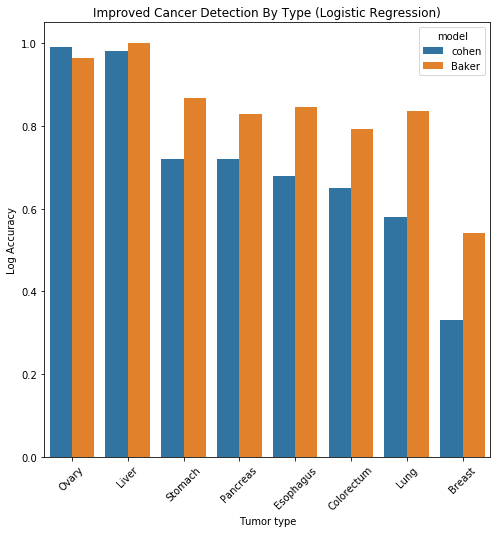

In [105]:
gen_bar_chart("Tumor type", "Log Accuracy", cancer_type,
              'log_accuracy_types', 'Improved Cancer Detection By Type (Logistic Regression)')

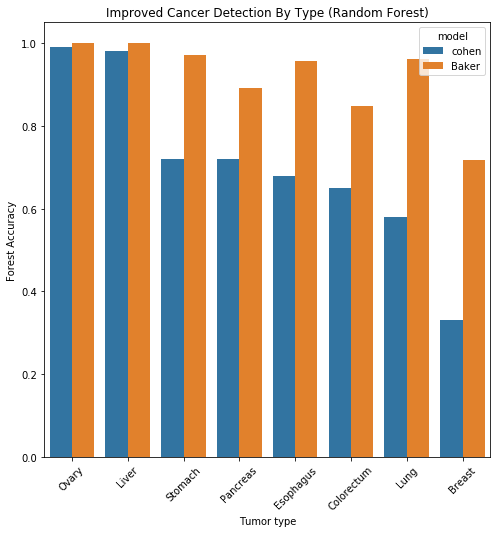

In [106]:
gen_bar_chart("Tumor type", "Forest Accuracy", cancer_type,
              'forest_accuracy_types', 'Improved Cancer Detection By Type (Random Forest)')

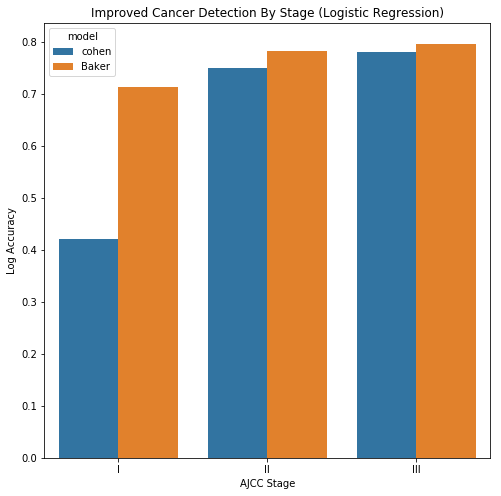

In [108]:
gen_bar_chart("AJCC Stage", "Log Accuracy", cancer_stage,
              'log_accuracy_stages', 'Improved Cancer Detection By Stage (Logistic Regression)', rotate=False)

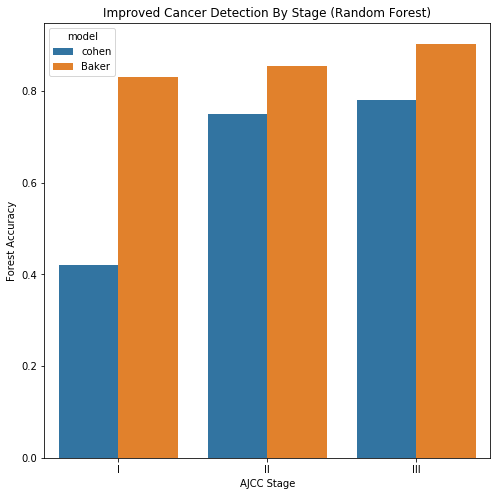

In [109]:
gen_bar_chart("AJCC Stage", "Forest Accuracy", cancer_stage,
              'forest_accuracy_stages', 'Improved Cancer Detection By Stage (Random Forest)', rotate=False)